# Практическое задание

## Задачи 2

Для задачи классификации обучить дерево решений
с использованием критериев разбиения Джини и Энтропии.
Сравнить качество классификации, сделать выводы.

## Решение

Обучен массив деревьев
с использование критериев Джини и Энтропии, а также
с варьированием минимальной длины выборки в листе и
максимальной глубины дерева.

Различия в качестве классификации заметны,
но не существенны в случаи отсутствия переобучения
(критерий Джини лучше на несколько процентов).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

from problem_2 import build, predict, \
    impurity_gini, information_gain, \
    error_matrix, error_metrics, \
    print_tree

In [2]:
def multimap(func, iterables):
    if isinstance(iterables, (list, tuple)):
        return list(map((lambda _: multimap(func, _)), iterables))
    else:
        return func(iterables)

In [3]:
def mapgrid(
    func: object, X: np.array, shape: tuple[int, int]
) -> tuple[np.array, np.array]:
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, shape[0]),
        np.linspace(y_min, y_max, shape[1])
    )

    zz = func(np.c_[xx.ravel(), yy.ravel()])
    zz = np.array(zz).reshape(shape)
    
    return xx, yy, zz

### Set parameters

In [4]:
dataset_parameters = {
    'n_samples': 500,
    'n_features': 2,
    'n_informative': 2,
    'n_redundant': 0,
    'n_repeated': 0,
    'n_classes': 2,
    'n_clusters_per_class': 2,
    'random_state': 5
}

split_parameters = {
    'test_size': .25,
    'random_state': 5
}

impurity_functions = impurity_gini, information_gain
max_level_parameters = 1, 11, 1
min_length_parameters = 1, 11, 1

max_levels = range(*max_level_parameters) 
min_lengths = range(*min_length_parameters)

metrics_indexes = {
    0: ('dataset', ('train', 'test')),
    1: ('impurity', ('impurity gini', 'information gain')),
    2: ('min length', min_lengths),
    3: ('max level', max_levels),
    4: ('metric', ('accuracy', 'precision', 'recall', 'f-score'))
}

preds_indexes = {
    0: ('impurity gini', 'information gain'),
    1: ('train', 'test')
}

colormap_parameters = {
    'base': ['red', 'blue'],
    'light': ['lightcoral', 'lightblue']
}

colormaps = {
    key: ListedColormap(colors=colors)
    for key, colors in colormap_parameters.items()
}

In [5]:
def multibuild(X: list[list], y: list) -> list[list[list]]:
    return [
        [
            [
                build(
                    X=X, y=y,
                    func_impurity=impurity_function,
                    len_min=min_length,
                    lev_max=max_level
                )
                for max_level in max_levels
            ]
            for min_length in min_lengths
        ]
        for impurity_function in impurity_functions
    ]

### Make dataset

In [6]:
X, y = make_classification(**dataset_parameters)

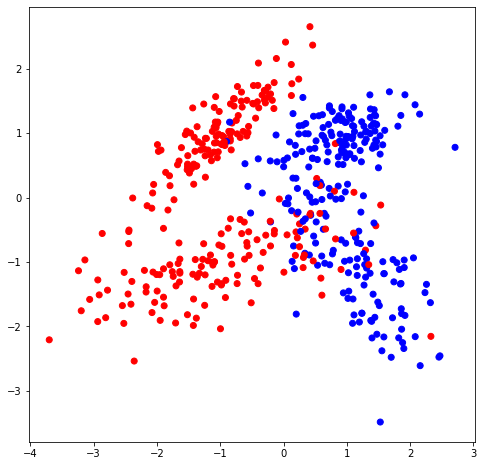

In [7]:
plt.figure(figsize=(8, 8))

plt.scatter(
    x=X[:, 0], y=X[:, 1], c=y,
    cmap=colormaps['base']
)

plt.show()

### Split dataset

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    **split_parameters
)

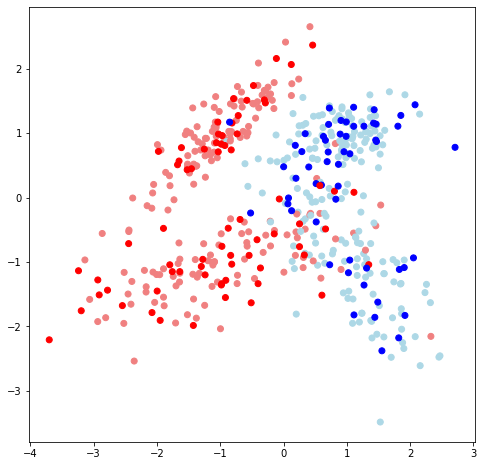

In [9]:
plt.figure(figsize=(8, 8))

plt.scatter(
    x=X_train[:, 0], y=X_train[:, 1], c=y_train,
    cmap=colormaps['light']
)
plt.scatter(
    x=X_test[:, 0], y=X_test[:, 1], c=y_test,
    cmap=colormaps['base']
)   

plt.show()

### Build trees

In [10]:
models = multibuild(X_train, y_train)

### Calculate metrics

In [11]:
metrics = [
    multimap(
        func=(
            lambda model:
            error_metrics(
                error_matrix(
                    a=predict(X=X, tree=model), y=y
                )
            )
        ),
        iterables=models
    )
    for X, y in ((X_train, y_train), (X_test, y_test))
]

metrics = np.array(metrics)

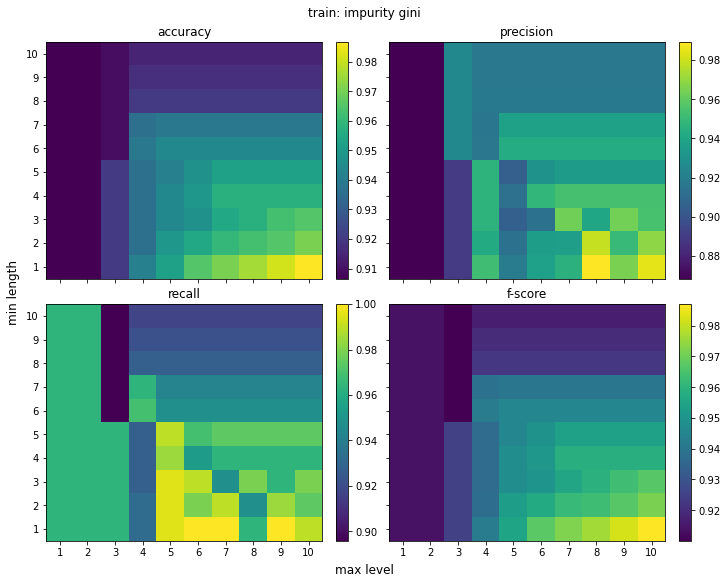

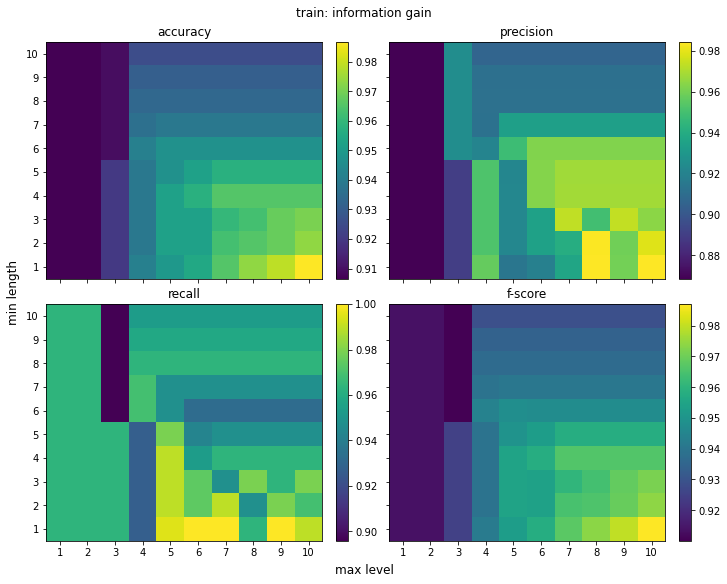

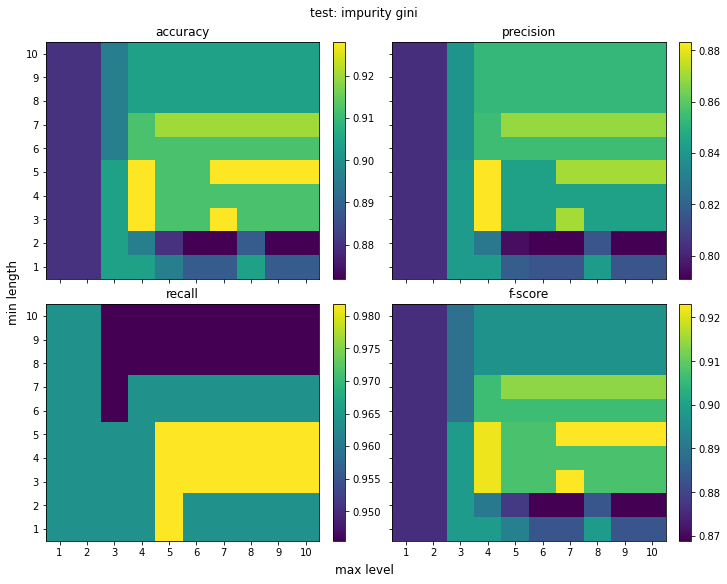

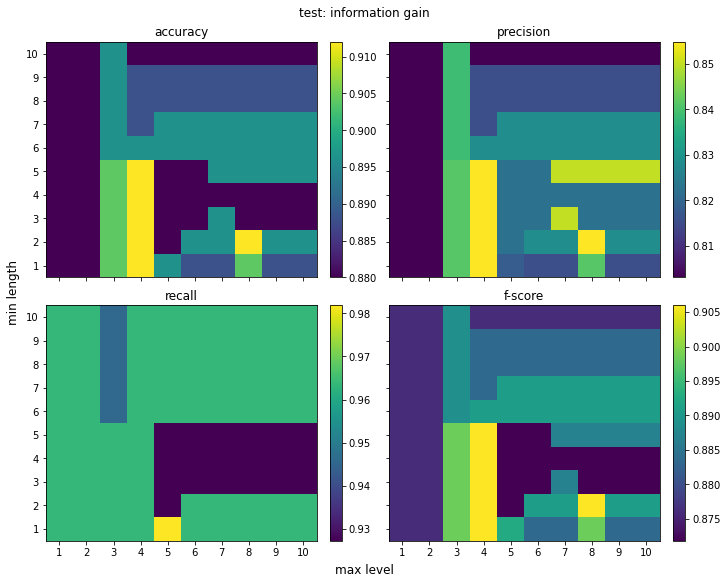

In [12]:
for i in range(len(metrics_indexes[0][1])):
    for j in range(len(metrics_indexes[1][1])):
        fig, axs = plt.subplots(
            nrows=2, ncols=2,
            sharex=True, sharey=True,
            figsize=(10, 8),
            constrained_layout=True
        )
        
        fig.supxlabel(metrics_indexes[3][0])
        fig.supylabel(metrics_indexes[2][0])
        fig.suptitle(metrics_indexes[0][1][i] + ': ' + metrics_indexes[1][1][j])
        
        for k in range(len(metrics_indexes[4][1])):
            ax = axs.flatten()[k]
            
            ax.set(
                title=metrics_indexes[4][1][k],
                # xlabel=metrics_indexes[3][0],
                # ylabel=metrics_indexes[2][0],
                xticks=metrics_indexes[3][1],
                yticks=metrics_indexes[2][1]
            )
            ax.label_outer()
            
            im = ax.pcolormesh(
                *np.meshgrid(metrics_indexes[3][1], metrics_indexes[2][1]),
                metrics[i, j, :, :, k],
                shading='auto'
            )
            fig.colorbar(im, ax=ax)            

### Make predictions

In [13]:
min_length = 5
max_level = 4

X_ = X_train, X_test
y_ = y_train, y_test

# y_pred_ = [
#     [predict(X, model) for X in X_]
#     for model in [
#         _[min_lengths.index(min_length)][max_levels.index(max_level)]
#         for _ in models
#     ]
# ]

y_pred_grid_ = [
    mapgrid(
        lambda X: predict(X, model),
        X,
        (X.shape[0], X.shape[0])
    )
    for model in [
        _[min_lengths.index(min_length)][max_levels.index(max_level)]
        for _ in models
    ]
]

In [14]:
print(
    '{} = {}'.format(
        metrics_indexes[2][0],
        min_length
    ),
    '{} = {}'.format(
        metrics_indexes[3][0],
        max_level
    ),
    sep='\n', end='\n\n'
)

for i in range(len(metrics_indexes[0][1])):
    print(
        '{}: {}'.format(
            metrics_indexes[0][0],
            metrics_indexes[0][1][i]
        )
    )
    for j in range(len(metrics_indexes[1][1])):
        print(
            '\t {}: {}'.format(
                metrics_indexes[1][0],
                metrics_indexes[1][1][j]
            )
        )
        for k in range(len(metrics_indexes[4][1])):
            print(
                '\t\t {}: {} = {:.3g}'.format(
                    metrics_indexes[4][0],
                    metrics_indexes[4][1][k],
                    metrics[
                        i, j,
                        metrics_indexes[2][1].index(min_length),
                        metrics_indexes[3][1].index(max_level),
                        k
                    ]
                )
            )

min length = 5
max level = 4

dataset: train
	 impurity: impurity gini
		 metric: accuracy = 0.936
		 metric: precision = 0.947
		 metric: recall = 0.927
		 metric: f-score = 0.937
	 impurity: information gain
		 metric: accuracy = 0.939
		 metric: precision = 0.952
		 metric: recall = 0.927
		 metric: f-score = 0.939
dataset: test
	 impurity: impurity gini
		 metric: accuracy = 0.928
		 metric: precision = 0.883
		 metric: recall = 0.964
		 metric: f-score = 0.922
	 impurity: information gain
		 metric: accuracy = 0.912
		 metric: precision = 0.855
		 metric: recall = 0.964
		 metric: f-score = 0.906


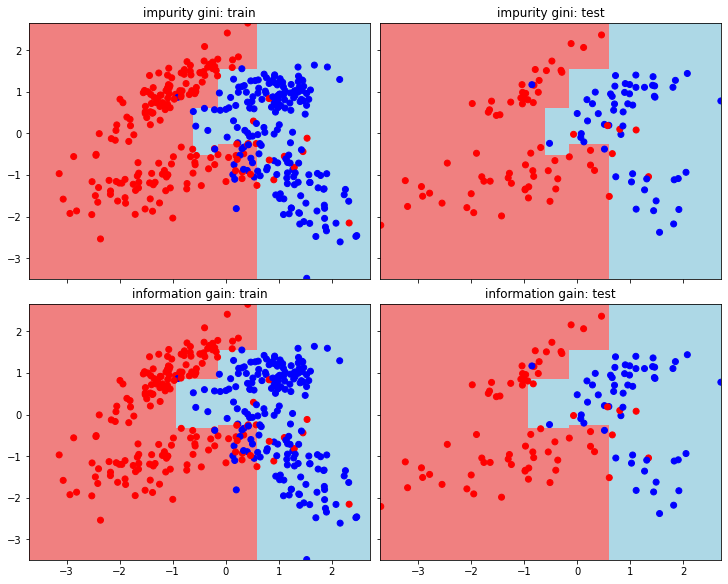

In [15]:
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    sharex=True, sharey=True,
    figsize=(10, 8),
    constrained_layout=True
)

for i in range(len(preds_indexes[0])):
    for j in range(len(preds_indexes[1])):
        ax = axs[i, j]

        ax.pcolormesh(
            *y_pred_grid_[i],
            cmap=colormaps['light'],
            shading='auto')
        
        ax.scatter(
            x=X_[j][:, 0], y=X_[j][:, 1], c=y_[j],
            cmap=colormaps['base']
        )

        ax.set_title(
            '{}: {}'.format(
                preds_indexes[0][i],
                preds_indexes[1][j]
            )
        )